In [1]:
#--- setup and import
import os, sys
import numpy as np
import pandas as pd
from importlib import reload
from datetime import time
import matplotlib.pyplot as plt
from importlib import reload

sys.path.insert(0, os.path.abspath(".."))

root = os.path.abspath("..")  # because your notebook is in /notebooks
if root not in sys.path:
    sys.path.append(root)

import src.feature_time as FT
import src.feature_volatility as FVOL
import src.feature_levels as FLEV

reload(FT)
reload(FVOL)
reload(FLEV)






<module 'src.feature_levels' from 'c:\\Users\\user\\Forex_prediction\\src\\feature_levels.py'>

### Read file and import time features related to FX market

In [2]:
# --- Config ---
CSV_PATH = "../data/clean/EUR_USD_COMBINED_2021-2025_4years.csv"   
TS_COL   = "Gmt time"                              #
USE_CYCLICAL = False                               # Importing date related data in cyclical format for better NN performance 
SAVE_FEATHER = "../data/clean/minutes_features_pdf.feather"


In [3]:
# Loading the file
# Currently data consists of 4 years of minute data for EUR/USD
# and has GMT time OHLC and Volume columns
df = pd.read_csv(CSV_PATH)
print("Loaded:", df.shape)
df.head(3)


Loaded: (1486245, 6)


,Gmt time,Open,High,Low,Close,Volume
0,2021-08-16 00:00:00,1.17939,1.17957,1.17937,1.17957,52.95
1,2021-08-16 00:01:00,1.17958,1.17963,1.17953,1.17953,14.39
2,2021-08-16 00:02:00,1.17954,1.17954,1.17944,1.17944,17.46


In [4]:
df = pd.read_csv(CSV_PATH, parse_dates=["Gmt time"])

# force Volume to be numeric (coerce errors into NaN)
df["Volume"] = pd.to_numeric(df["Volume"], errors="coerce")

# now drop NA/zero Volume
before = len(df)
df = df.dropna(subset=["Volume"])
df = df[df["Volume"] > 0]
after = len(df)

print(f"Dropped {before - after} rows ({100*(before-after)/before:.2f}%) due to NA/zero Volume")

# sanity check
print("Unique Volume values (sample):", df["Volume"].unique()[:20])


Dropped 0 rows (0.00%) due to NA/zero Volume
Unique Volume values (sample): [52.95 14.39 17.46 16.03 12.33 28.38 32.48 28.08  9.   14.38 13.38 22.08
 26.02 16.37 16.7  81.06 49.89 19.25 17.33 22.85]


In [5]:
df = FT.add_ny_session_markers(
    df,
    dt_col="Gmt time",
    market_open_local="09:30",
    market_close_local="16:00",
    warmup_minutes=30,
    roll_weekends=True,   # <- important
)


In [6]:
def _to_utc(series: pd.Series) -> pd.Series:
    s = pd.to_datetime(series, utc=False, errors="coerce")
    # if tz-naive, assume it's already UTC; if tz-aware (e.g., America/New_York), convert to UTC
    if getattr(s.dt, "tz", None) is None:
        return s.dt.tz_localize("UTC")
    return s.dt.tz_convert("UTC")


In [7]:
def normalize_session_markers(df_in: pd.DataFrame, dt_col: str = TS_COL, warmup_minutes: int = 30) -> pd.DataFrame:
    d = df_in.copy()
    # Ensure dt_utc
    if "dt_utc" not in d.columns:
        d["dt_utc"] = pd.to_datetime(d[dt_col], utc=True)
    # Build UTC markers from NY-local if missing
    if "ny_open_utc" not in d.columns:
        if "ny_open_ny" in d.columns:
            d["ny_open_utc"] = _to_utc(d["ny_open_ny"])
    if "ny_close_utc" not in d.columns:
        if "ny_close_ny" in d.columns:
            d["ny_close_utc"] = _to_utc(d["ny_close_ny"])
    if "ny_warmup_end_utc" not in d.columns:
        if "ny_warmup_end_ny" in d.columns:
            d["ny_warmup_end_utc"] = _to_utc(d["ny_warmup_end_ny"])
        elif "ny_open_utc" in d.columns:
            d["ny_warmup_end_utc"] = d["ny_open_utc"] + pd.Timedelta(minutes=warmup_minutes)
    # Final sanity: we must have these
    needed = ["ny_open_utc","ny_warmup_end_utc","ny_close_utc","date_us_open"]
    missing = [c for c in needed if c not in d.columns]
    if missing:
        raise KeyError(f"Missing session markers after normalization: {missing}")
    return d

df = normalize_session_markers(df, dt_col=TS_COL, warmup_minutes=30)

In [8]:
# stricter or looser binary flag:
df = FVOL.attach_volatility_score(
    df,
    dt_col="Gmt time",
    atr_lookback=14,
    atr_method="sma",   # or "ema"
    k_atr=1.4,         # raise for stricter (fewer volatile days)
    cap_lo=0.7, cap_hi=1.3
)

# sanity: share of volatile days
pct = df.drop_duplicates("date_us_open")["is_volatile"].mean() * 100
print(f"Volatile days ≈ {pct:.1f}% (k_atr={1.25})")

Volatile days ≈ 14.0% (k_atr=1.25)


In [9]:

reload(FLEV)

df = FLEV.compute_levels(
    df,
    ts_col="Gmt time",
    vwap_mode="rolling_24h",
    vwap_alpha=0.25,
    l1_use=True,
    ib_k=1.30,                # ← push L1 further out
    vol_score_col="vol_score",
    vol_scale_l1=True,
    vol_scale_fv=False,
    scale_mode="up_only",     # ← only widen, never shrink on quiet days
)


In [10]:
import pandas as pd
import numpy as np

# --- 1) Row count ---
print(f"Total rows in df: {len(df):,}")

# --- 2) Distinct FV/L1 values per US day in August with start times ---

# pick level columns that actually exist in df
candidate_cols = [
    "FV_low_adj_active","FV_mid_adj_active","FV_high_adj_active",
    "L1_dn_active","L1_mid_dn_active","L1_mid_up_active","L1_up_active"
]
level_cols = [c for c in candidate_cols if c in df.columns]
if not level_cols:
    raise ValueError("No *_active level columns found. Make sure compute_levels() has been run.")

# we’ll use UTC timestamps for start times
if "dt_utc" not in df.columns:
    raise ValueError("dt_utc column is required.")

# restrict to August (any year)
aug = df[df["dt_utc"].dt.month == 8].copy()
if aug.empty:
    print("No August data found.")
else:
    # ensure date_us_open is datetime (date) for grouping
    aug["date_us_open"] = pd.to_datetime(aug["date_us_open"])

    records = []
    for (day), g in aug.sort_values("dt_utc").groupby("date_us_open", sort=True):
        # within each US day, find segments where a level changes value
        g = g.sort_values("dt_utc")
        for col in level_cols:
            # change points for this column within the day
            mask = g[col].ne(g[col].shift())
            starts = g.loc[mask, ["dt_utc", col]]
            # record each distinct value with its first start time
            for _, row in starts.iterrows():
                val = row[col]
                # skip NaNs (can happen pre-init)
                if pd.isna(val):
                    continue
                records.append({
                    "date_us_open": day.date(),
                    "level": col,
                    "value": float(val),
                    "start_time_utc": row["dt_utc"]
                })

    # tidy DataFrame with one row per (day, level, distinct value) and its start time
    august_levels = pd.DataFrame.from_records(records).sort_values(
        ["date_us_open","level","start_time_utc"]
    ).reset_index(drop=True)

    # show a quick preview
    print("\nDistinct FV/L1 values per US trading day in August (first start times, UTC):")
    display_cols = ["date_us_open","level","value","start_time_utc"]
    print(august_levels[display_cols].head(20))

    # --- Optional: per-day counts of distinct values for each level ---
    counts = (
        august_levels
        .groupby(["date_us_open","level"])["value"]
        .nunique()
        .rename("distinct_values")
        .reset_index()
        .pivot(index="date_us_open", columns="level", values="distinct_values")
        .fillna(0).astype(int)
        .sort_index()
    )
    print("\nCount of distinct values per day (August):")
    print(counts)


Total rows in df: 1,486,245

Distinct FV/L1 values per US trading day in August (first start times, UTC):
   date_us_open               level     value            start_time_utc
0    2021-08-16  FV_high_adj_active  1.178455 2021-08-16 14:00:00+00:00
1    2021-08-16   FV_low_adj_active  1.177375 2021-08-16 14:00:00+00:00
2    2021-08-16   FV_mid_adj_active  1.177915 2021-08-16 14:00:00+00:00
3    2021-08-16        L1_dn_active  1.175971 2021-08-16 14:00:00+00:00
4    2021-08-16    L1_mid_dn_active  1.176673 2021-08-16 14:00:00+00:00
5    2021-08-16    L1_mid_up_active  1.179157 2021-08-16 14:00:00+00:00
6    2021-08-16        L1_up_active  1.179859 2021-08-16 14:00:00+00:00
7    2021-08-17  FV_high_adj_active  1.178455 2021-08-17 04:00:00+00:00
8    2021-08-17  FV_high_adj_active  1.174606 2021-08-17 14:00:00+00:00
9    2021-08-17   FV_low_adj_active  1.177375 2021-08-17 04:00:00+00:00
10   2021-08-17   FV_low_adj_active  1.173776 2021-08-17 14:00:00+00:00
11   2021-08-17   FV_mid_adj_a

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_levels_styled(
    df: pd.DataFrame,
    start_date=None, end_date=None, ndays=3,
    tz: str = "UTC",
    show_updates: bool = True,
    show_price: bool = True,
):
    """
    Plot Close + ACTIVE levels with requested colors & FV gray fill.

    Colors:
      - FV boundaries: green
      - L1 (outer): purple
      - Midway (L1↔FV): blue
      - FV zone (FV_low..FV_high): light gray fill
      - FV mid & halves: green but faint (lower alpha)
    """

    # --- window selection by US trading day ---
    x = df.copy()
    x["dt_utc"] = pd.to_datetime(x["dt_utc"], utc=True)

    if start_date is not None:
        start_date = pd.to_datetime(start_date).date()
        if end_date is None:
            end_date = (pd.to_datetime(start_date) + pd.Timedelta(days=ndays-1)).date()
        else:
            end_date = pd.to_datetime(end_date).date()
        mask = (x["date_us_open"] >= start_date) & (x["date_us_open"] <= end_date)
        x = x.loc[mask]
        title_range = f"{start_date} → {end_date}"
    else:
        title_range = "full range"

    if x.empty:
        print("No data in selected window.")
        return

    # --- x-axis timezone ---
    xaxis = x["dt_utc"].dt.tz_convert("America/New_York") if tz == "America/New_York" else x["dt_utc"]

    # --- columns we need (ACTIVE variants so levels hold for the day) ---
    need = [
        "FV_low_adj_active","FV_mid_adj_active","FV_high_adj_active",
        "FV_half_dn_active","FV_half_up_active",
        "L1_dn_active","L1_mid_dn_active","L1_mid_up_active","L1_up_active",
    ]
    have = [c for c in need if c in x.columns]
    missing = [c for c in need if c not in x.columns]
    if len(have) < 3:
        raise ValueError(f"Missing active level columns: {missing}. Run compute_levels() first.")

    # --- plot ---
    fig, ax = plt.subplots(figsize=(14,6))

    # FV gray zone first (so everything else sits on top)
    if {"FV_low_adj_active","FV_high_adj_active"}.issubset(have):
        ax.fill_between(
            xaxis,
            x["FV_low_adj_active"],
            x["FV_high_adj_active"],
            color="gray", alpha=0.12, zorder=1, label="FV zone"
        )

    # Price
    if show_price and "Close" in x.columns:
        ax.plot(xaxis, x["Close"], color="black", lw=1.0, label="Close", zorder=3)

    # FV boundaries (green, solid)
    if "FV_low_adj_active" in have:
        ax.plot(xaxis, x["FV_low_adj_active"], color="green", lw=1.4, label="FV_low", zorder=4)
    if "FV_high_adj_active" in have:
        ax.plot(xaxis, x["FV_high_adj_active"], color="green", lw=1.4, label="FV_high", zorder=4)

    # FV mid & halves (fainter green)
    if "FV_mid_adj_active" in have:
        ax.plot(xaxis, x["FV_mid_adj_active"], color="green", alpha=0.35, lw=1.1, label="FV_mid", zorder=4)
    if "FV_half_dn_active" in have:
        ax.plot(xaxis, x["FV_half_dn_active"], color="green", alpha=0.25, lw=1.0, label="FV_half_dn", zorder=4)
    if "FV_half_up_active" in have:
        ax.plot(xaxis, x["FV_half_up_active"], color="green", alpha=0.25, lw=1.0, label="FV_half_up", zorder=4)

    # L1 outer (purple)
    if "L1_dn_active" in have:
        ax.plot(xaxis, x["L1_dn_active"], color="purple", lw=1.3, label="L1_dn", zorder=4)
    if "L1_up_active" in have:
        ax.plot(xaxis, x["L1_up_active"], color="purple", lw=1.3, label="L1_up", zorder=4)

    # Midway lines between L1 and FV (blue)
    if "L1_mid_dn_active" in have:
        ax.plot(xaxis, x["L1_mid_dn_active"], color="blue", lw=1.1, label="Mid_dn (L1↔FV)", zorder=4)
    if "L1_mid_up_active" in have:
        ax.plot(xaxis, x["L1_mid_up_active"], color="blue", lw=1.1, label="Mid_up (L1↔FV)", zorder=4)

    # Optional: vertical update markers at warmup end
    if show_updates and "ny_warmup_end_utc" in x.columns:
        ups = (x[["date_us_open","ny_warmup_end_utc"]]
               .drop_duplicates("date_us_open")
               .sort_values("date_us_open"))
        ups_x = ups["ny_warmup_end_utc"].dt.tz_convert("America/New_York") if tz=="America/New_York" else ups["ny_warmup_end_utc"]
        for t in ups_x:
            ax.axvline(t, color="gray", alpha=0.35, lw=0.8, linestyle="--", zorder=2)

    ax.set_title(f"Price + Levels ({title_range}, shown in {tz})")
    ax.set_ylabel("Price")
    ax.grid(True, alpha=0.25)

    # dedupe legend labels
    handles, labels = ax.get_legend_handles_labels()
    seen, h2, l2 = set(), [], []
    for h, l in zip(handles, labels):
        if l not in seen:
            seen.add(l); h2.append(h); l2.append(l)
    ax.legend(h2, l2, loc="upper left", ncol=3, fontsize=8)

    plt.show()


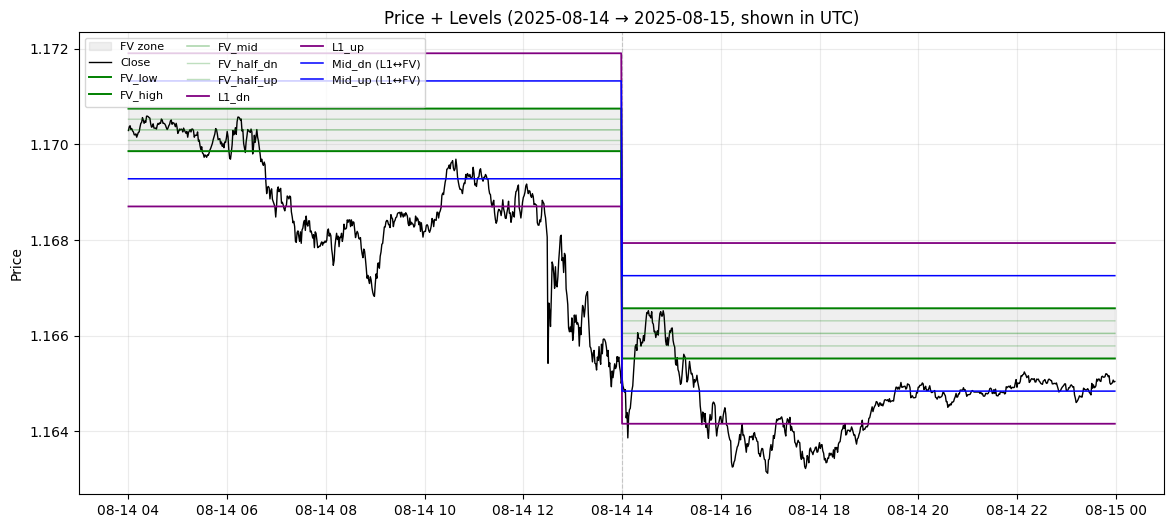

In [59]:
# 3 days starting Aug 21, 2021 (UTC x-axis)
plot_levels_styled(df, start_date="2025-08-14", ndays=2, tz="UTC")




,Gmt time,Open,High,Low,Close,Volume,dt_utc,dt_ny,date_us_open,ny_open_ny,...,L1_up_prev,FV_low_adj_active,FV_mid_adj_active,FV_high_adj_active,FV_half_dn_active,FV_half_up_active,L1_dn_active,L1_mid_dn_active,L1_mid_up_active,L1_up_active
0,2021-08-16 00:00:00,1.17939,1.17957,1.17937,1.17957,52.95,2021-08-16 00:00:00+00:00,2021-08-15 20:00:00-04:00,2021-08-16,2021-08-16 09:30:00-04:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-08-16 00:01:00,1.17958,1.17963,1.17953,1.17953,14.39,2021-08-16 00:01:00+00:00,2021-08-15 20:01:00-04:00,2021-08-16,2021-08-16 09:30:00-04:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-08-16 00:02:00,1.17954,1.17954,1.17944,1.17944,17.46,2021-08-16 00:02:00+00:00,2021-08-15 20:02:00-04:00,2021-08-16,2021-08-16 09:30:00-04:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-08-16 00:03:00,1.17945,1.17964,1.17945,1.17964,16.03,2021-08-16 00:03:00+00:00,2021-08-15 20:03:00-04:00,2021-08-16,2021-08-16 09:30:00-04:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-08-16 00:04:00,1.17964,1.17973,1.17964,1.17969,12.33,2021-08-16 00:04:00+00:00,2021-08-15 20:04:00-04:00,2021-08-16,2021-08-16 09:30:00-04:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1486240,2025-08-14 23:55:00,1.16499,1.16502,1.16498,1.16500,5.40,2025-08-14 23:55:00+00:00,2025-08-14 19:55:00-04:00,2025-08-14,2025-08-14 09:30:00-04:00,...,1.171905,1.165521,1.166046,1.166571,1.165784,1.166309,1.164156,1.164839,1.167254,1.167936
1486241,2025-08-14 23:56:00,1.16499,1.16501,1.16498,1.16501,4.08,2025-08-14 23:56:00+00:00,2025-08-14 19:56:00-04:00,2025-08-14,2025-08-14 09:30:00-04:00,...,1.171905,1.165521,1.166046,1.166571,1.165784,1.166309,1.164156,1.164839,1.167254,1.167936
1486242,2025-08-14 23:57:00,1.16501,1.16509,1.16498,1.16507,12.93,2025-08-14 23:57:00+00:00,2025-08-14 19:57:00-04:00,2025-08-14,2025-08-14 09:30:00-04:00,...,1.171905,1.165521,1.166046,1.166571,1.165784,1.166309,1.164156,1.164839,1.167254,1.167936
1486243,2025-08-14 23:58:00,1.16502,1.16509,1.16499,1.16503,23.40,2025-08-14 23:58:00+00:00,2025-08-14 19:58:00-04:00,2025-08-14,2025-08-14 09:30:00-04:00,...,1.171905,1.165521,1.166046,1.166571,1.165784,1.166309,1.164156,1.164839,1.167254,1.167936


### Backtest

In [26]:
from datetime import date, timedelta

def backtest_days(
    df,
    days=None,                    # list like ["2025-08-08","2025-08-07"] OR None
    start=None, end=None,         # or a date range: "YYYY-MM-DD"
    buffer_pips=2.0,
    spread_pips=1.0,
    slippage_pips=0.5,
    conservative_intrabar=True,
    min_fv_range_pips=0.0,        # skip days with tiny FV range (e.g., 5.0)
    verbose=True,
):
    """
    Run the 'inside → outside FV' strategy over multiple US days.

    Pass either:
      - days=[...], OR
      - start="YYYY-MM-DD", end="YYYY-MM-DD"
    """
    # build the day list
    if days is None:
        if start is None or end is None:
            raise ValueError("Provide either 'days' or 'start'+'end'.")
        d0 = pd.to_datetime(start).date()
        d1 = pd.to_datetime(end).date()
        if d1 < d0:
            d0, d1 = d1, d0
        days = []
        cur = d0
        while cur <= d1:
            days.append(cur.isoformat())
            cur += timedelta(days=1)

    all_trades = []
    skipped_small = []

    # precompute FV range per day for the min_fv_range filter
    day_meta = (
        df.drop_duplicates("date_us_open")
          .assign(date_us_open=pd.to_datetime(df["date_us_open"]))
    )
    # Use active FV bounds after warmup for a stable per-day range
    per_day = (
        df.groupby("date_us_open")
          .apply(lambda g: pd.Series({
              "fv_range": float((g["FV_high_adj_active"] - g["FV_low_adj_active"]).iloc[-1])
                            if "FV_high_adj_active" in g and "FV_low_adj_active" in g else np.nan
          }))
          .reset_index()
    )
    per_day["date_us_open"] = pd.to_datetime(per_day["date_us_open"]).dt.date
    fv_map = {d:r for d, r in zip(per_day["date_us_open"], per_day["fv_range"])}

    for d in days:
        d_date = pd.to_datetime(d).date()
        fv_rng = fv_map.get(d_date, np.nan)
        if (not np.isnan(fv_rng)) and (min_fv_range_pips > 0.0):
            if fv_rng < (min_fv_range_pips * 1e-4):  # convert pips to price
                skipped_small.append((d_date, fv_rng))
                if verbose:
                    print(f"Skip {d_date} - FV range too small ({fv_rng*1e4:.2f} pips < {min_fv_range_pips})")
                continue

        try:
            t = backtest_one_day(
                df,
                day=d,
                buffer_pips=buffer_pips,
                spread_pips=spread_pips,
                slippage_pips=slippage_pips,
                conservative_intrabar=conservative_intrabar,
            )
            if t is not None and len(t):
                all_trades.append(t)
        except Exception as e:
            if verbose:
                print(f"[{d}] error: {e}")

    if not all_trades:
        print("No trades in the selected period.")
        return pd.DataFrame()

    trades = pd.concat(all_trades, ignore_index=True)

    # quick summary
    wins = (trades["pips"] > 0).sum()
    total = len(trades)
    print("\n=== MULTI-DAY SUMMARY ===")
    print(f"days tested: {len(days)} | trades: {total} | win%: {wins/total*100:.1f}%")
    print(f"total pips: {trades['pips'].sum():.1f} | avg pips/trade: {trades['pips'].mean():.2f}")
    if skipped_small:
        print(f"skipped for small FV range: {len(skipped_small)} day(s)")

    return trades


In [51]:
_ = backtest_one_day(df, day="2025-08-08", buffer_pips=2.0)


  date_us_open   side                entry_time    entry        tp        sl  \
0   2025-08-08   long 2025-08-08 18:53:00+00:00  1.16565  1.165650  1.165083   
1   2025-08-08  short 2025-08-11 09:15:00+00:00  1.16417  1.164201  1.164768   
2   2025-08-08  short 2025-08-11 09:26:00+00:00  1.16421  1.164201  1.164768   

                  exit_time      exit reason  pips  
0 2025-08-08 18:56:00+00:00  1.165650     TP -0.00  
1 2025-08-11 09:15:00+00:00  1.164868     SL -6.98  
2 2025-08-11 09:27:00+00:00  1.164201     TP  0.09  

Summary: trades=3, win%=33.3%, pips_sum=-6.9, pips_avg=-2.3


In [52]:
df

,Gmt time,Open,High,Low,Close,Volume,dt_utc,dt_ny,date_us_open,ny_open_ny,...,L1_up_prev,FV_low_adj_active,FV_mid_adj_active,FV_high_adj_active,FV_half_dn_active,FV_half_up_active,L1_dn_active,L1_mid_dn_active,L1_mid_up_active,L1_up_active
0,2021-08-16 00:00:00,1.17939,1.17957,1.17937,1.17957,52.95,2021-08-16 00:00:00+00:00,2021-08-15 20:00:00-04:00,2021-08-16,2021-08-16 09:30:00-04:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-08-16 00:01:00,1.17958,1.17963,1.17953,1.17953,14.39,2021-08-16 00:01:00+00:00,2021-08-15 20:01:00-04:00,2021-08-16,2021-08-16 09:30:00-04:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-08-16 00:02:00,1.17954,1.17954,1.17944,1.17944,17.46,2021-08-16 00:02:00+00:00,2021-08-15 20:02:00-04:00,2021-08-16,2021-08-16 09:30:00-04:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-08-16 00:03:00,1.17945,1.17964,1.17945,1.17964,16.03,2021-08-16 00:03:00+00:00,2021-08-15 20:03:00-04:00,2021-08-16,2021-08-16 09:30:00-04:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-08-16 00:04:00,1.17964,1.17973,1.17964,1.17969,12.33,2021-08-16 00:04:00+00:00,2021-08-15 20:04:00-04:00,2021-08-16,2021-08-16 09:30:00-04:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1486240,2025-08-14 23:55:00,1.16499,1.16502,1.16498,1.16500,5.40,2025-08-14 23:55:00+00:00,2025-08-14 19:55:00-04:00,2025-08-14,2025-08-14 09:30:00-04:00,...,1.171905,1.165521,1.166046,1.166571,1.165784,1.166309,1.164156,1.164839,1.167254,1.167936
1486241,2025-08-14 23:56:00,1.16499,1.16501,1.16498,1.16501,4.08,2025-08-14 23:56:00+00:00,2025-08-14 19:56:00-04:00,2025-08-14,2025-08-14 09:30:00-04:00,...,1.171905,1.165521,1.166046,1.166571,1.165784,1.166309,1.164156,1.164839,1.167254,1.167936
1486242,2025-08-14 23:57:00,1.16501,1.16509,1.16498,1.16507,12.93,2025-08-14 23:57:00+00:00,2025-08-14 19:57:00-04:00,2025-08-14,2025-08-14 09:30:00-04:00,...,1.171905,1.165521,1.166046,1.166571,1.165784,1.166309,1.164156,1.164839,1.167254,1.167936
1486243,2025-08-14 23:58:00,1.16502,1.16509,1.16499,1.16503,23.40,2025-08-14 23:58:00+00:00,2025-08-14 19:58:00-04:00,2025-08-14,2025-08-14 09:30:00-04:00,...,1.171905,1.165521,1.166046,1.166571,1.165784,1.166309,1.164156,1.164839,1.167254,1.167936


### BAcktest 2

In [57]:
import pandas as pd
import numpy as np
from datetime import timedelta

PIP = 1e-4  # EURUSD

def backtest_one_day(
    df: pd.DataFrame,
    day: str,                  # "YYYY-MM-DD" (US session date)
    buffer_pips: float = 2.0,  # close must exceed boundary by this buffer
    spread_pips: float = 1.0,  # half applied on entry, half on exit
    slippage_pips: float = 0.5,
    conservative_intrabar: bool = True,  # if TP & SL hit same bar, count SL first
):
    """Inside→Outside FV breakout to L1_mid, then re-enter to L1 with FV-boundary stop."""
    buf  = buffer_pips * PIP
    spr  = spread_pips * PIP
    slip = slippage_pips * PIP

    # ---- slice one US session: [today warmup_end, next warmup_end) ----
    day_date = pd.to_datetime(day).date()
    rows_today = df[df["date_us_open"] == day_date]
    if rows_today.empty:
        raise ValueError(f"No rows for date_us_open={day_date}")

    warmup_today = rows_today["ny_warmup_end_utc"].iloc[0]

    unique_days = list(pd.Series(df["date_us_open"]).dropna().unique())
    unique_days.sort()
    try:
        idx = unique_days.index(day_date)
        next_day = unique_days[idx + 1]
        warmup_next = df[df["date_us_open"] == next_day]["ny_warmup_end_utc"].iloc[0]
    except Exception:
        warmup_next = rows_today["ny_close_utc"].iloc[-1]

    ses = df[(df["dt_utc"] >= warmup_today) & (df["dt_utc"] < warmup_next)].copy()
    ses = ses.sort_values("dt_utc").reset_index(drop=True)

    need = [
        "dt_utc","Open","High","Low","Close",
        "FV_low_adj_active","FV_mid_adj_active","FV_high_adj_active",
        "L1_mid_dn_active","L1_mid_up_active","L1_dn_active","L1_up_active",
    ]
    missing = [c for c in need if c not in ses.columns]
    if missing:
        raise ValueError(f"Missing columns: {missing}")

    def inside_fv(i: int) -> bool:
        if i == 0: 
            return False
        c = ses.loc[i-1, "Close"]
        return (ses.loc[i-1, "FV_low_adj_active"] <= c <= ses.loc[i-1, "FV_high_adj_active"])

    trade = None
    log = []
    reentry_pending_side = None   # "long" or "short" after base trade TP
    reentry_taken_side   = set()  # avoid multiple re-entries per side per session

    for i in range(1, len(ses)):
        row = ses.loc[i]
        prev = ses.loc[i-1]

        # -------- Re-entry (only when flat, after a TP, once per side) --------
        if trade is None and reentry_pending_side is not None and reentry_pending_side not in reentry_taken_side:
            if reentry_pending_side == "long":
                if row["Close"] > row["L1_mid_up_active"] + buf:
                    entry = row["Close"] + slip + spr/2
                    tp = row["L1_up_active"] + buf  # TP at outer L1 (+buffer)
                    sl = row["FV_high_adj_active"]  # SL at FV boundary
                    trade = dict(side="long", entry_time=row["dt_utc"], entry=entry, tp=tp, sl=sl, tag="reentry")
                    reentry_taken_side.add("long")
                    reentry_pending_side = None
            elif reentry_pending_side == "short":
                if row["Close"] < row["L1_mid_dn_active"] - buf:
                    entry = row["Close"] - slip - spr/2
                    tp = row["L1_dn_active"] - buf
                    sl = row["FV_low_adj_active"]
                    trade = dict(side="short", entry_time=row["dt_utc"], entry=entry, tp=tp, sl=sl, tag="reentry")
                    reentry_taken_side.add("short")
                    reentry_pending_side = None

        # -------- Base entries (inside → outside FV with close beyond boundary+buffer) --------
        if trade is None and inside_fv(i):
            # long breakout up
            if row["Close"] > row["FV_high_adj_active"] + buf:
                entry = row["Close"] + slip + spr/2
                tp = row["L1_mid_up_active"]
                sl = 0.5 * (row["FV_high_adj_active"] + row["FV_mid_adj_active"])
                trade = dict(side="long", entry_time=row["dt_utc"], entry=entry, tp=tp, sl=sl, tag="base")

            # short breakout down
            elif row["Close"] < row["FV_low_adj_active"] - buf:
                entry = row["Close"] - slip - spr/2
                tp = row["L1_mid_dn_active"]
                sl = 0.5 * (row["FV_low_adj_active"] + row["FV_mid_adj_active"])
                trade = dict(side="short", entry_time=row["dt_utc"], entry=entry, tp=tp, sl=sl, tag="base")

        # -------- Manage exits --------
        if trade is not None:
            hi, lo = row["High"], row["Low"]
            exit_reason, exit_px = None, None

            if trade["side"] == "long":
                hit_sl = lo <= trade["sl"]
                hit_tp = hi >= trade["tp"]
                if hit_sl and hit_tp and conservative_intrabar:
                    exit_reason = "SL_samebar"; exit_px = trade["sl"] - slip - spr/2
                elif hit_tp and hit_sl and not conservative_intrabar:
                    exit_reason = "TP_samebar"; exit_px = trade["tp"] + slip - spr/2
                elif hit_sl:
                    exit_reason = "SL"; exit_px = trade["sl"] - slip - spr/2
                elif hit_tp:
                    exit_reason = "TP"; exit_px = trade["tp"] + slip - spr/2

            else:  # short
                hit_sl = hi >= trade["sl"]
                hit_tp = lo <= trade["tp"]
                if hit_sl and hit_tp and conservative_intrabar:
                    exit_reason = "SL_samebar"; exit_px = trade["sl"] + slip + spr/2
                elif hit_tp and hit_sl and not conservative_intrabar:
                    exit_reason = "TP_samebar"; exit_px = trade["tp"] - slip + spr/2
                elif hit_sl:
                    exit_reason = "SL"; exit_px = trade["sl"] + slip + spr/2
                elif hit_tp:
                    exit_reason = "TP"; exit_px = trade["tp"] - slip + spr/2

            # time exit at last bar of session
            last_bar = (i == len(ses) - 1)
            if exit_reason is None and last_bar:
                exit_reason = "Time"
                exit_px = (row["Close"] - (slip + spr/2)) if trade["side"]=="short" else (row["Close"] + (slip + spr/2))

            if exit_reason is not None:
                pnl = (exit_px - trade["entry"]) if trade["side"]=="long" else (trade["entry"] - exit_px)
                pnl_pips = pnl / PIP

                log.append({
                    "date_us_open": day_date,
                    "tag": trade.get("tag","base"),
                    "side": trade["side"],
                    "entry_time": trade["entry_time"],
                    "entry": round(trade["entry"], 6),
                    "tp": round(trade["tp"], 6),
                    "sl": round(trade["sl"], 6),
                    "exit_time": row["dt_utc"],
                    "exit": round(exit_px, 6),
                    "reason": exit_reason,
                    "pips": round(pnl_pips, 2),
                })

                # set/clear re-entry flag
                if exit_reason.startswith("TP"):
                    reentry_pending_side = trade["side"]   # allow re-entry once
                else:
                    reentry_pending_side = None            # no re-entry after SL/Time

                trade = None

    trades = pd.DataFrame(log)
    if trades.empty:
        print(f"No trades on {day_date}.")
        return trades

    wins = (trades["pips"] > 0).sum()
    print(trades)
    print("\nSummary:",
          f"trades={len(trades)},",
          f"win%={(wins/len(trades))*100:.1f}%,",
          f"pips_sum={trades['pips'].sum():.1f},",
          f"pips_avg={trades['pips'].mean():.2f}")
    return trades


def backtest_days(
    df: pd.DataFrame,
    days=None,                 # list like ["2025-08-07","2025-08-08"] OR None
    start=None, end=None,      # or date range
    buffer_pips: float = 2.0,
    spread_pips: float = 1.0,
    slippage_pips: float = 0.5,
    conservative_intrabar: bool = True,
    min_fv_range_pips: float = 0.0,  # skip days with tiny FV range (e.g., 5.0)
    verbose: bool = True,
):
    """Multi-day wrapper calling backtest_one_day with same rules."""
    # build day list
    if days is None:
        if start is None or end is None:
            raise ValueError("Provide either 'days' or 'start'+'end'.")
        d0 = pd.to_datetime(start).date()
        d1 = pd.to_datetime(end).date()
        if d1 < d0: d0, d1 = d1, d0
        days = [(d0 + timedelta(days=k)).isoformat() for k in range((d1 - d0).days + 1)]

    # precompute per-day FV range to allow skipping tiny structures
    per_day = (
        df.groupby("date_us_open")
          .apply(lambda g: float((g["FV_high_adj_active"].iloc[-1] - g["FV_low_adj_active"].iloc[-1]))
                if "FV_high_adj_active" in g and "FV_low_adj_active" in g else np.nan)
          .rename("fv_range")
          .reset_index()
    )
    per_day["date_us_open"] = pd.to_datetime(per_day["date_us_open"]).dt.date
    fv_map = dict(zip(per_day["date_us_open"], per_day["fv_range"]))

    all_trades = []
    skipped = 0

    for d in days:
        d_date = pd.to_datetime(d).date()
        fv_rng = fv_map.get(d_date, np.nan)
        if (not np.isnan(fv_rng)) and (min_fv_range_pips > 0.0) and (fv_rng < min_fv_range_pips * PIP):
            skipped += 1
            if verbose:
                print(f"Skip {d} — FV range {fv_rng/PIP:.2f} pips < {min_fv_range_pips}")
            continue

        try:
            t = backtest_one_day(
                df, d, buffer_pips=buffer_pips,
                spread_pips=spread_pips, slippage_pips=slippage_pips,
                conservative_intrabar=conservative_intrabar
            )
            if len(t): all_trades.append(t)
        except Exception as e:
            if verbose: print(f"[{d}] error: {e}")

    if not all_trades:
        print("No trades in selected period.")
        return pd.DataFrame()

    trades = pd.concat(all_trades, ignore_index=True)
    wins = (trades["pips"] > 0).sum()
    print("\n=== MULTI-DAY SUMMARY ===")
    print(f"days tested: {len(days)} | trades: {len(trades)} | win%: {wins/len(trades)*100:.1f}%")
    print(f"total pips: {trades['pips'].sum():.1f} | avg pips/trade: {trades['pips'].mean():.2f} | skipped (small FV): {skipped}")
    return trades


In [68]:
# One specific day
_ = backtest_one_day(df, day="2025-07-03", buffer_pips=2.0)



  date_us_open   tag   side                entry_time    entry        tp  \
0   2025-07-03  base  short 2025-07-03 20:44:00+00:00  1.17549  1.173871   

         sl                 exit_time      exit reason  pips  
0  1.176368 2025-07-03 23:30:00+00:00  1.176468     SL -9.78  

Summary: trades=1, win%=0.0%, pips_sum=-9.8, pips_avg=-9.78


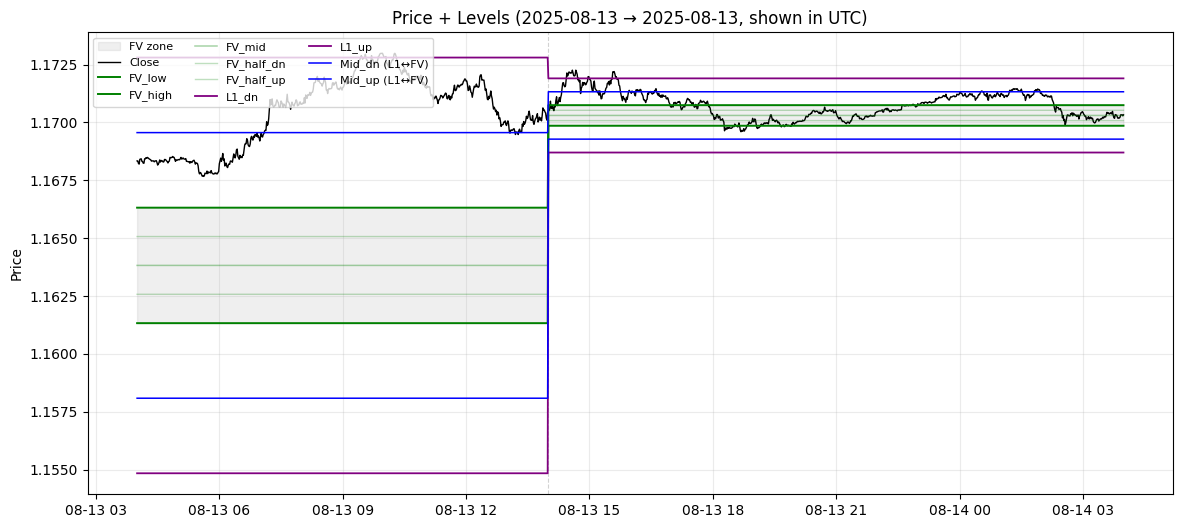

In [63]:
# 3 days starting Aug 21, 2021 (UTC x-axis)
plot_levels_styled(df, start_date="2025-08-13", ndays=1, tz="UTC")




In [70]:
import pandas as pd
import numpy as np
from datetime import timedelta

PIP = 1e-4  # EURUSD

def backtest_one_day(
    df: pd.DataFrame,
    day: str,                  # "YYYY-MM-DD" (US session date)
    buffer_pips: float = 2.0,  # close must exceed FV boundary by this buffer
    spread_pips: float = 1.0,  # half applied on entry, half on exit
    slippage_pips: float = 0.5,
    conservative_intrabar: bool = True,  # if TP & SL hit same bar, count SL first
):
    """Inside→Outside FV breakout to L1_mid, then re-enter to L1 with FV-boundary stop."""
    buf  = buffer_pips * PIP
    spr  = spread_pips * PIP
    slip = slippage_pips * PIP

    # ---- slice one US session: [today warmup_end, next warmup_end) ----
    day_date = pd.to_datetime(day).date()
    rows_today = df[df["date_us_open"] == day_date]
    if rows_today.empty:
        # No such US day in data (weekend/holiday/not present)
        return pd.DataFrame(columns=[
            "date_us_open","tag","side","entry_time","entry","tp","sl",
            "exit_time","exit","reason","pips"
        ])

    warmup_today = rows_today["ny_warmup_end_utc"].iloc[0]

    # find next session boundary
    unique_days = list(pd.Series(df["date_us_open"]).dropna().unique())
    unique_days = [pd.to_datetime(d).date() for d in unique_days]
    unique_days.sort()
    try:
        idx = unique_days.index(day_date)
        next_day = unique_days[idx + 1]
        warmup_next = df[df["date_us_open"] == next_day]["ny_warmup_end_utc"].iloc[0]
    except Exception:
        # if no next day available, fallback to session close
        warmup_next = rows_today["ny_close_utc"].iloc[-1]

    ses = df[(df["dt_utc"] >= warmup_today) & (df["dt_utc"] < warmup_next)].copy()
    ses = ses.sort_values("dt_utc").reset_index(drop=True)

    need = [
        "dt_utc","Open","High","Low","Close",
        "FV_low_adj_active","FV_mid_adj_active","FV_high_adj_active",
        "L1_mid_dn_active","L1_mid_up_active","L1_dn_active","L1_up_active",
    ]
    missing = [c for c in need if c not in ses.columns]
    if missing or ses.empty:
        return pd.DataFrame(columns=[
            "date_us_open","tag","side","entry_time","entry","tp","sl",
            "exit_time","exit","reason","pips"
        ])

    def inside_fv(i: int) -> bool:
        if i == 0:
            return False
        c = ses.loc[i-1, "Close"]
        return (ses.loc[i-1, "FV_low_adj_active"] <= c <= ses.loc[i-1, "FV_high_adj_active"])

    trade = None
    log = []
    reentry_pending_side = None   # "long"/"short" after base trade TP
    reentry_taken_side   = set()  # avoid multiple re-entries per side per session

    for i in range(1, len(ses)):
        row = ses.loc[i]

        # -------- Re-entry (only when flat, after a TP, once per side) --------
        if trade is None and reentry_pending_side is not None and reentry_pending_side not in reentry_taken_side:
            if reentry_pending_side == "long":
                if row["Close"] > row["L1_mid_up_active"] + buf:
                    entry = row["Close"] + slip + spr/2
                    tp = row["L1_up_active"] + buf       # TP at outer L1 (+buffer)
                    sl = row["FV_high_adj_active"]        # SL at FV boundary
                    trade = dict(side="long", entry_time=row["dt_utc"], entry=entry, tp=tp, sl=sl, tag="reentry")
                    reentry_taken_side.add("long")
                    reentry_pending_side = None
            elif reentry_pending_side == "short":
                if row["Close"] < row["L1_mid_dn_active"] - buf:
                    entry = row["Close"] - slip - spr/2
                    tp = row["L1_dn_active"] - buf
                    sl = row["FV_low_adj_active"]
                    trade = dict(side="short", entry_time=row["dt_utc"], entry=entry, tp=tp, sl=sl, tag="reentry")
                    reentry_taken_side.add("short")
                    reentry_pending_side = None

        # -------- Base entries (inside → outside FV with close beyond boundary+buffer) --------
        if trade is None and inside_fv(i):
            # long breakout up
            if row["Close"] > row["FV_high_adj_active"] + buf:
                entry = row["Close"] + slip + spr/2
                tp = row["L1_mid_up_active"]
                sl = 0.5 * (row["FV_high_adj_active"] + row["FV_mid_adj_active"])
                trade = dict(side="long", entry_time=row["dt_utc"], entry=entry, tp=tp, sl=sl, tag="base")

            # short breakout down
            elif row["Close"] < row["FV_low_adj_active"] - buf:
                entry = row["Close"] - slip - spr/2
                tp = row["L1_mid_dn_active"]
                sl = 0.5 * (row["FV_low_adj_active"] + row["FV_mid_adj_active"])
                trade = dict(side="short", entry_time=row["dt_utc"], entry=entry, tp=tp, sl=sl, tag="base")

        # -------- Manage exits --------
        if trade is not None:
            hi, lo = row["High"], row["Low"]
            exit_reason, exit_px = None, None

            if trade["side"] == "long":
                hit_sl = lo <= trade["sl"]
                hit_tp = hi >= trade["tp"]
                if hit_sl and hit_tp and conservative_intrabar:
                    exit_reason = "SL_samebar"; exit_px = trade["sl"] - slip - spr/2
                elif hit_tp and hit_sl and not conservative_intrabar:
                    exit_reason = "TP_samebar"; exit_px = trade["tp"] + slip - spr/2
                elif hit_sl:
                    exit_reason = "SL"; exit_px = trade["sl"] - slip - spr/2
                elif hit_tp:
                    exit_reason = "TP"; exit_px = trade["tp"] + slip - spr/2

            else:  # short
                hit_sl = hi >= trade["sl"]
                hit_tp = lo <= trade["tp"]
                if hit_sl and hit_tp and conservative_intrabar:
                    exit_reason = "SL_samebar"; exit_px = trade["sl"] + slip + spr/2
                elif hit_tp and hit_sl and not conservative_intrabar:
                    exit_reason = "TP_samebar"; exit_px = trade["tp"] - slip + spr/2
                elif hit_sl:
                    exit_reason = "SL"; exit_px = trade["sl"] + slip + spr/2
                elif hit_tp:
                    exit_reason = "TP"; exit_px = trade["tp"] - slip + spr/2

            # time exit at last bar of session
            last_bar = (i == len(ses) - 1)
            if exit_reason is None and last_bar:
                exit_reason = "Time"
                exit_px = (row["Close"] - (slip + spr/2)) if trade["side"]=="short" \
                          else (row["Close"] + (slip + spr/2))

            if exit_reason is not None:
                pnl = (exit_px - trade["entry"]) if trade["side"]=="long" else (trade["entry"] - exit_px)
                pnl_pips = pnl / PIP

                log.append({
                    "date_us_open": day_date,
                    "tag": trade.get("tag","base"),
                    "side": trade["side"],
                    "entry_time": trade["entry_time"],
                    "entry": round(trade["entry"], 6),
                    "tp": round(trade["tp"], 6),
                    "sl": round(trade["sl"], 6),
                    "exit_time": row["dt_utc"],
                    "exit": round(exit_px, 6),
                    "reason": exit_reason,
                    "pips": round(pnl_pips, 2),
                })

                # set/clear re-entry flag
                if exit_reason.startswith("TP"):
                    reentry_pending_side = trade["side"]   # allow re-entry once for that side
                else:
                    reentry_pending_side = None            # no re-entry after SL/Time

                trade = None

    trades = pd.DataFrame(log)
    return trades


def backtest_days(
    df: pd.DataFrame,
    days=None,                 # list like ["2025-08-07","2025-08-08"] OR None
    start=None, end=None,      # or date range
    buffer_pips: float = 2.0,
    spread_pips: float = 1.0,
    slippage_pips: float = 0.5,
    conservative_intrabar: bool = True,
    min_fv_range_pips: float = 0.0,  # skip days with tiny FV range (e.g., 5.0)
    verbose: bool = True,
):
    """Multi-day wrapper calling backtest_one_day with same rules (uses real days from data)."""

    # --- build the list of real US days present in df within [start,end] ---
    if days is None:
        if start is None or end is None:
            raise ValueError("Provide either 'days' or 'start'+'end'.")
        start_d = pd.to_datetime(start).date()
        end_d   = pd.to_datetime(end).date()
        a = pd.to_datetime(df["date_us_open"]).dt.date
        mask = (a >= start_d) & (a <= end_d)
        real_days = sorted(set(a[mask]))
        days = [d.isoformat() for d in real_days]

    if not days:
        if verbose: print("No US days in the selected window.")
        return pd.DataFrame()

    # precompute per-day FV range (after warmup) for min-range filter
    per_day = (
        df.groupby("date_us_open")
          .apply(lambda g: float((g["FV_high_adj_active"].iloc[-1] - g["FV_low_adj_active"].iloc[-1]))
                if "FV_high_adj_active" in g and "FV_low_adj_active" in g else np.nan)
          .rename("fv_range")
          .reset_index()
    )
    per_day["date_us_open"] = pd.to_datetime(per_day["date_us_open"]).dt.date
    fv_map = dict(zip(per_day["date_us_open"], per_day["fv_range"]))

    all_trades = []
    skipped = 0

    for d in days:
        d_date = pd.to_datetime(d).date()
        fv_rng = fv_map.get(d_date, np.nan)
        if (not np.isnan(fv_rng)) and (min_fv_range_pips > 0.0) and (fv_rng < min_fv_range_pips * PIP):
            skipped += 1
            if verbose:
                print(f"Skip {d} — FV range {fv_rng/PIP:.2f} pips < {min_fv_range_pips}")
            continue

        t = backtest_one_day(
            df, d,
            buffer_pips=buffer_pips,
            spread_pips=spread_pips,
            slippage_pips=slippage_pips,
            conservative_intrabar=conservative_intrabar
        )
        if len(t):
            all_trades.append(t)

    if not all_trades:
        if verbose: print("No trades in selected period.")
        return pd.DataFrame()

    trades = pd.concat(all_trades, ignore_index=True)

    if verbose:
        wins = (trades["pips"] > 0).sum()
        print("\n=== MULTI-DAY SUMMARY ===")
        print(f"days tested: {len(days)} | trades: {len(trades)} | win%: {wins/len(trades)*100:.1f}%")
        print(f"total pips: {trades['pips'].sum():.1f} | avg pips/trade: {trades['pips'].mean():.2f} | skipped (small FV): {skipped}")

    return trades


In [78]:
# One day (e.g., 2025-08-13)
_ = backtest_one_day(df, day="2025-08-01", buffer_pips=2.0)

# Whole August 2025 (built from actual data days)
trades_aug = backtest_days(
    df,
    start="2021-01-12", end="2025-08-14",
    buffer_pips=2.0,
    min_fv_range_pips=0.0,   # set to 5.0 later if you want to skip tiny structures
    conservative_intrabar=False,
)

# Inspect / save
print(trades_aug.head())
print("Trades in August:", len(trades_aug))
trades_aug.to_csv("trades_2025_08.csv", index=False)


C:\Users\user\AppData\Local\Temp\ipykernel_39696\2987381611.py:205: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: float((g["FV_high_adj_active"].iloc[-1] - g["FV_low_adj_active"].iloc[-1]))



=== MULTI-DAY SUMMARY ===
days tested: 1043 | trades: 2318 | win%: 42.6%
total pips: -5941.4 | avg pips/trade: -2.56 | skipped (small FV): 0
  date_us_open      tag   side                entry_time    entry        tp  \
0   2021-08-16     base  short 2021-08-17 02:33:00+00:00  1.17704  1.176673   
1   2021-08-16  reentry  short 2021-08-17 06:28:00+00:00  1.17630  1.175771   
2   2021-08-18     base   long 2021-08-18 18:03:00+00:00  1.17235  1.172683   
3   2021-08-18     base   long 2021-08-18 18:09:00+00:00  1.17239  1.172683   
4   2021-08-18     base   long 2021-08-18 18:29:00+00:00  1.17232  1.172683   

         sl                 exit_time      exit reason   pips  
0  1.177645 2021-08-17 03:25:00+00:00  1.176673     TP   3.67  
1  1.177375 2021-08-17 07:42:00+00:00  1.177475     SL -11.75  
2  1.171738 2021-08-18 18:03:00+00:00  1.171638     SL  -7.12  
3  1.171738 2021-08-18 18:09:00+00:00  1.171638     SL  -7.52  
4  1.171738 2021-08-18 18:42:00+00:00  1.171638     SL  -6.82  

In [79]:
# One day (e.g., 2025-08-13)
_ = backtest_one_day(df, day="2025-08-01", buffer_pips=2.0)

# Whole August 2025 (built from actual data days)
trades_aug = backtest_days(
    df,
    start="2021-01-12", end="2025-08-14",
    buffer_pips=2.0,
    min_fv_range_pips=0.0,   # set to 5.0 later if you want to skip tiny structures
    conservative_intrabar=True,
)

# Inspect / save
print(trades_aug.head())
print("Trades in August:", len(trades_aug))
trades_aug.to_csv("trades_2025_08.csv", index=False)


C:\Users\user\AppData\Local\Temp\ipykernel_39696\2987381611.py:205: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: float((g["FV_high_adj_active"].iloc[-1] - g["FV_low_adj_active"].iloc[-1]))



=== MULTI-DAY SUMMARY ===
days tested: 1043 | trades: 2293 | win%: 41.7%
total pips: -6526.0 | avg pips/trade: -2.85 | skipped (small FV): 0
  date_us_open      tag   side                entry_time    entry        tp  \
0   2021-08-16     base  short 2021-08-17 02:33:00+00:00  1.17704  1.176673   
1   2021-08-16  reentry  short 2021-08-17 06:28:00+00:00  1.17630  1.175771   
2   2021-08-18     base   long 2021-08-18 18:03:00+00:00  1.17235  1.172683   
3   2021-08-18     base   long 2021-08-18 18:09:00+00:00  1.17239  1.172683   
4   2021-08-18     base   long 2021-08-18 18:29:00+00:00  1.17232  1.172683   

         sl                 exit_time      exit reason   pips  
0  1.177645 2021-08-17 03:25:00+00:00  1.176673     TP   3.67  
1  1.177375 2021-08-17 07:42:00+00:00  1.177475     SL -11.75  
2  1.171738 2021-08-18 18:03:00+00:00  1.171638     SL  -7.12  
3  1.171738 2021-08-18 18:09:00+00:00  1.171638     SL  -7.52  
4  1.171738 2021-08-18 18:42:00+00:00  1.171638     SL  -6.82  